# Step 3: Fitting Peaks
Notebook Code: [![License: MIT](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://www.gnu.org/licenses/gpl-3.0) Notebook Prose: [![License: CC BY 4.0](https://img.shields.io/badge/License-CC_BY_4.0-lightgrey.svg)](https://creativecommons.org/licenses/by/4.0/)

---

The meat of `hplc-py` is its ability to take in windowed regions of a chromatogram 
and fit a number of peaks such that the chromatogram in that region is well reconstructed. 
As is the theme in these notebooks, it's easier to look at a chromatogram and see 
what the reconstituted signals should like than to do it quantitatively. 

Ideally, one would have a physical model that would describe how an analyte interacts 
with the stationary phase of the chromatography column and a generative model that 
would capture the statistical distribution of the measurements as a function of time.
However, having this in chromatography is exceedingly rare, so we are left with 
phenomenological descriptions of peak shape that we relate to chemical species and 
concentrations through calibration curves and control experiments. This is what 
`hplc-py` excels at–phenomenological quantitative description of signals in a chromatogram.
It is important to note that `hplc-py` does **not** provide a model of the components 
of the chromatogram but rather fits the parameters of a minimal number of convolved 
signals that can capture the observed data in the chromatogram. In this notebook,
we outline how this fitting procedure is executed and how the total chromatographic 
signal is reconstructed. 



## The Skew-Normal Distribution 

In `hplc-py`, we consider that each detected maximum in a chromatogram results from 
a single compound $i$ whose time-dependent signal intensity $S_i$ can be phenomenologically 
well described by an amplitude-weighted [skew normal](https://en.wikipedia.org/wiki/Skew_normal_distribution) distribution. Mathematically, this is defined as

$$
S_i(t) = \frac{A}{\sqrt{2\pi\sigma_i^2}} \exp\left[\frac{(t - \tau_i)^2}{2\sigma_i^2}\right]\left[1 + \text{erf}\left(\frac{\alpha_i (t - \tau_i)}{\sqrt{2\sigma^2}}\right)\right], \tag{1}
$$

where $\text{erf}$ is the [error function](https://en.wikipedia.org/wiki/Error_function), $A$ is the amplitude, $\tau$ is the retention time, $\sigma^2$ is 
the signal variance, and $\alpha$ is the skew parameter. The skew normal distribution is 
used because the skew parameter $\alpha$ can break symmetry, allowing for heavily 
tailed signals. When the distribution is unskewed, meaning $\alpha = 0$, Eq. 1 simplifies to 
a Normal distribution symmetric about $\tau$. To get a sense of how $\alpha$ 
impacts the resulting signal, we can use `scipy.stats.skewnormal` to examine 
the amplitude-weighted output,

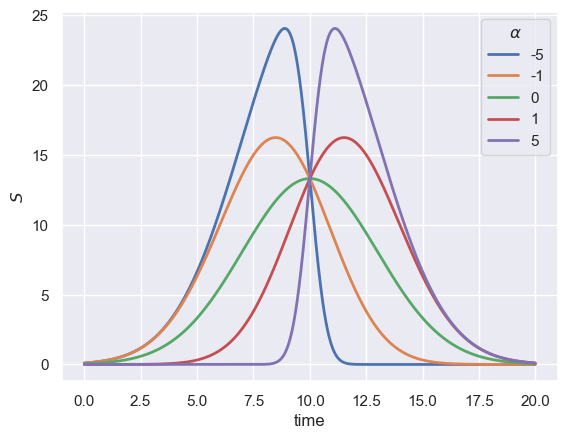

In [1]:
import numpy as np 
import pandas as pd 
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Set a range of skew parameters to demonstrate the signal as a function of time
alpha_range = [-5, -1, 0, 1, 5]
time = np.arange(0, 20, 0.01 )

# Set constants for each signal
A = 100
tau = 10
sigma = 3
for alpha in alpha_range:
    # Compute the skew normal distribution and plot the resulting signal.
    signal = A * scipy.stats.skewnorm(alpha, loc=tau, scale=sigma).pdf(time)
    plt.plot(time, signal, label=alpha, lw=2) 

# Add necessary labels
plt.xlabel('time')
plt.ylabel('$S$')
plt.legend(title=r'$\alpha$')

When the skew parameter $\alpha$ is large and negative, the signal is heavily
skewed towards shorter retention times. Even though all signals in this plot
have different heights and locations of the maxima, they all have identical
values for $A$, $\tau$, and $\sigma$. The flexibility of $\alpha$ in defining the 
signal trace allows for a broad array of peak shapes to be well described by 
this distribution.

## Fitting Peak Windows
As described in the notebook for Step 2, a chromatogram is broken down into
multiple "peak windows" which likely contain overlapping analyte signals. Each 
window is fitted independently, which assumes that distant peaks have no influence 
on each other. As an example, let's look at a real peak window from a sample chromatogram.


Performing baseline correction: 100%|██████████| 299/299 [00:00<00:00, 2725.64it/s]


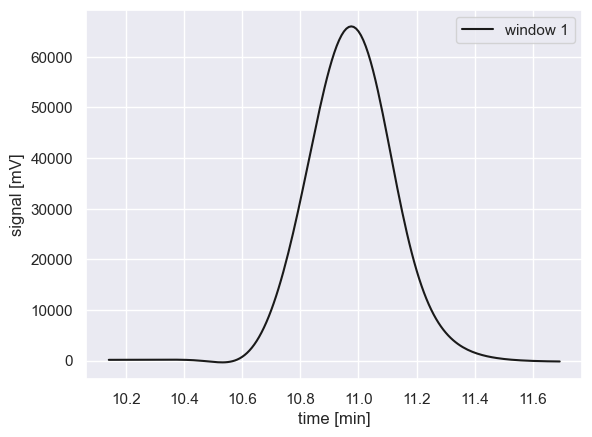

In [2]:
from hplc.quant import Chromatogram
import pandas as pd

# Load an example chromatogram and correct the baseline
df = pd.read_csv('data/sample_chromatogram.txt')
chrom  = Chromatogram(df, cols={'time':'time_min', 'signal':'intensity_mV'},
                      time_window=[10, 20])
chrom.correct_baseline()

# Assign the peak windows with a modified buffer and prominence filter
windows = chrom._assign_windows(buffer=50, prominence=0.01)

# Get the first peak window and plot
first_peak = windows[(windows['window_type']=='peak') & (windows['window_id']==1)]
plt.plot(first_peak['time_min'], first_peak['intensity_mV_corrected'], 'k-', label='window 1')
plt.xlabel('time [min]')
plt.ylabel('signal [mV]')
plt.legend()

To determine the properties of this peak (including its area which is proportional
to concentration), we will find the best-fit parameters using a non-linear least 
squares [trust region](https://en.wikipedia.org/wiki/Trust_region) fitting method
as is implemented in `scipy.optimize.curve_fit` which is a robust estimation 
algorithm for bounded problems. 

To do so, we must provide i) initial guesses for the parameters $[A, \tau, \sigma, \alpha]$
and ii) reasonable bounds on their values. 

### Default settings for initial guesses of parameters
In `hplc-py`, initial guesses are set given the properties of the observed 
chromatogram. These default parameter guesses are:

* $A_0 \rightarrow$ the observed value of the chromatogram at the location of the maxima
* $\tau_0 \rightarrow$ the observed time-location of the maxima 
* $\sigma_0 \rightarrow$ one-half of the observed peak width at its half-maximal value
* $\alpha_0 \rightarrow$ 0, which guesses that the peak is approximately Gaussian.

These values are determined using peak measurements returned by `scipy.signal.find_peaks`
and `scipy.signal.peak_widths`. These properties are accessible via the 
chromatogram attribute `.window_props` 

In [3]:
# Set the initial guesses from the window properties
props = chrom.window_props[1]
p0 = [props['amplitude'][0],
     props['location'][0],
     props['width'][0] / 2, 
     0]
p0

[65992.999952423, 10.98, 0.16630057317687066, 0]

### Default bounds for parameters
By default, `hplc-py` applies broad, permissive bounds on these parameters given 
information of the chromatogram. The default bounds given to each parameter are 

* $A \in [0.01 \times A_0, 100 \times A_0]$ where $A_0$ is the initial guess for the amplitude.
* $\tau \in [t_{min}, t_{max}]$ where $t_{min}$ and $t_{max}$ correspond to the minimum and maximum times in the peak window.
* $\sigma_{bounds} \in [dt, \frac{t_{max} - t_{min}}{2}]$ where $dt$ corresponds to the time sampling interval of the chromatogram.
* $\alpha \in (-\inf, +\inf)$.

These bounds can be overridden for all peak inferences by providing a dictionary 
of their values, as is specified in the documentation for `hplc.quant.Chromatogram.fit_peaks`.

In [4]:
# Give initial bounds for the parameters (lower, upper)
bounds = [[], []]
bounds[0] = [p0[0] * 0.1, first_peak['time_min'].min(), chrom._dt, -np.inf]
bounds[1] = [p0[0] * 10, first_peak['time_min'].max(), 0.5 * (first_peak['time_min'].max() - first_peak['time_min'].min()), np.inf]

### Optimization of parameters
Given initial guesses and parameter bounds, the best-fit parameters are estimated 
by calling `scipy.optimize.curve_fit` on the observed data in the peak widow. The 
cost function is defined as a method `_fit_skewnorms` of a `Chromatogram`.

In [5]:
import scipy.optimize

# Perform the fit
param_opt, _ = scipy.optimize.curve_fit(chrom._fit_skewnorms, first_peak['time_min'],
                                        first_peak['intensity_mV_corrected'],
                                        p0=p0, bounds=bounds)
print(f'Optimal parameters (amplitude, location, scale, skew) : {param_opt}')

Optimal parameters (amplitude, location, scale, skew) : [2.33773945e+04 1.09020036e+01 1.59217385e-01 7.03685471e-01]


With the optimal parameters estimated, we can compare the inferred signal to 
the observed chromatogram 

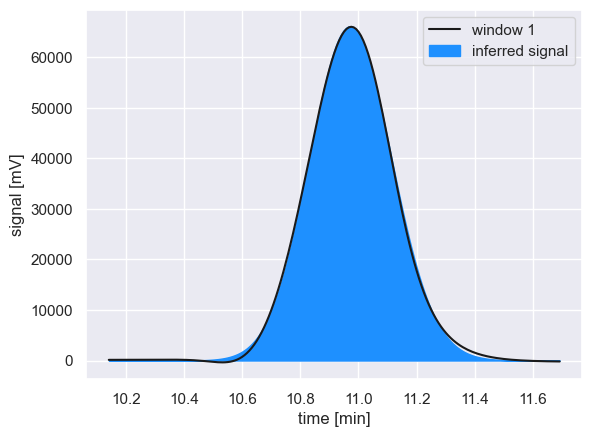

In [6]:
# Compute the amplitude-weighted skewnorm with the inferred parameters
fit = param_opt[0] * scipy.stats.skewnorm(param_opt[3], loc=param_opt[1], scale=param_opt[2]).pdf(first_peak['time_min'])

# Plot the data and the observed peak
plt.plot(first_peak['time_min'], first_peak['intensity_mV_corrected'], 'k-', label='window 1')
plt.fill_between(first_peak['time_min'], fit, color='dodgerblue', label='inferred signal')
plt.xlabel('time [min]')
plt.ylabel('signal [mV]')
plt.legend()

With an adequate reconstruction of the observed peak, the signal area is computed 
by integrating the signal over the entire time range of the peak window, and 
the procedure is repeated for the next peak window.

---

<small> © Griffin Chure, 2024. This notebook and the code within are released under a 
[Creative-Commons CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) and 
[GPLv3](https://www.gnu.org/licenses/gpl-3.0) license, respectively.</small>
